Aubrey Winger

Question 1

Part a

In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy.random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
import pymc as pm
import arviz as az
import graphviz

In [4]:
path = "/Users/aubrey/Downloads"
filename = "Haiti_Image.tif"
im = Image.open(filename)
imArray = np.array(im)
nrows, ncols, nbands = np.shape(imArray)

In [5]:
X = np.reshape(imArray,[nrows*ncols,nbands])
model = GaussianMixture(n_components=4, tol=0.1)
model.fit(X)
yhat = model.predict(X)

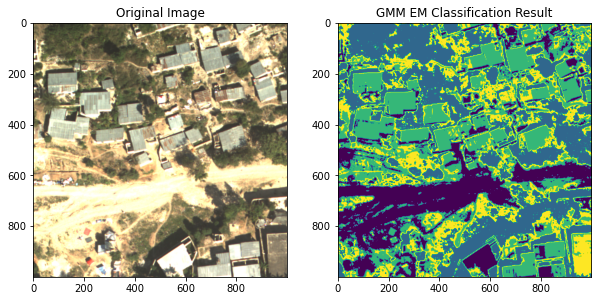

In [6]:
GMM_image=np.reshape(yhat,[nrows,ncols])
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans.fit(X)
kmeans_yhat = kmeans.predict(X)
kmeans_image = np.reshape(kmeans_yhat,[nrows,ncols])
plt.figure(figsize = (10,8))
plt.subplots_adjust(left=None,bottom=0.2,right=None,top=0.9,wspace=None,hspace=0.5)
plt.subplot(121)
plt.imshow(imArray)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(GMM_image)
plt.title('GMM EM Classification Result')
plt.show()

plt.show()

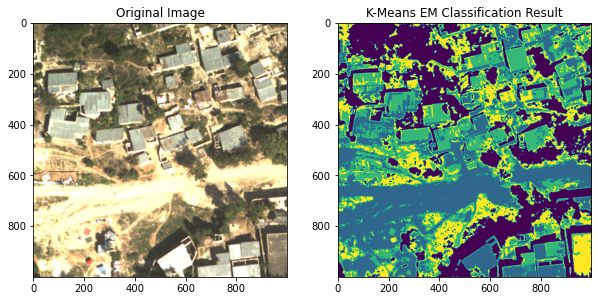

In [7]:
plt.figure(figsize = (10,8))
plt.subplots_adjust(left=None,bottom=0.2,right=None,top=0.9,wspace=None,hspace=0.5)
plt.subplot(121)
plt.imshow(imArray)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(kmeans_image)
plt.title('K-Means EM Classification Result')
plt.show()

plt.show()

The clustering shapes are very similar. It looks like the four categories are roads, two types of vegetation, and structures. The cluster colors are different, but this is because colors are just randomly assigned to each cluster. The main difference is that with GMM, you get a probability of being in each one of the four clusters (soft classification), but with K means it is a hard classification.

Part b

$P(k|x_n, \theta, P(k))= \frac{P(x_n|\theta)P(k)}{\sum_{j=1}^{K} P(f|x_n,\beta_j)P(f)}$
for k=1,...,K and K is the number of clusters

Part c

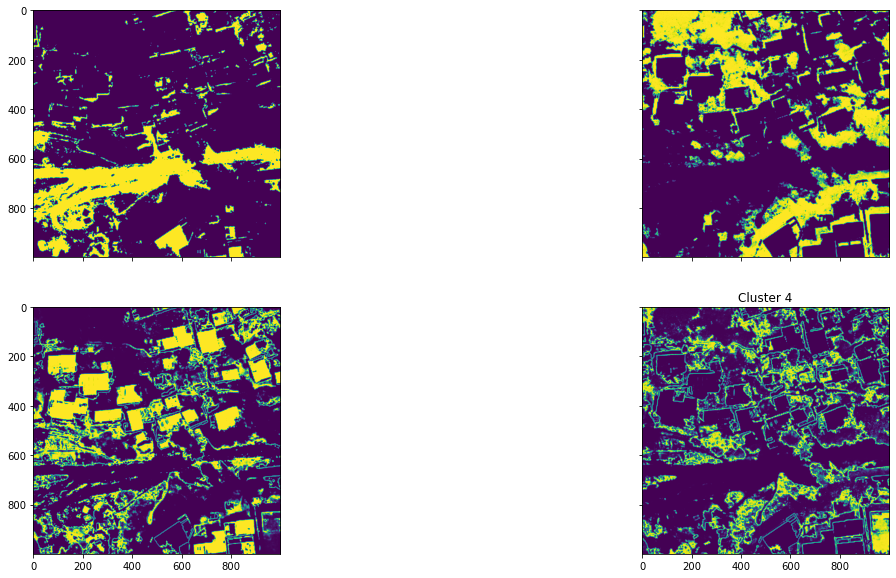

In [11]:
pred_probs = model.predict_proba(X)

Cluster=list()
for i in range(4):
    Cluster.append(np.reshape(pred_probs[:,i],[nrows,ncols]))
    
fig, axs = plt.subplots(2,2,figsize=(20,10),sharex=True,sharey=True)
axs[0,0].imshow(Cluster[0])
plt.title('Cluster 1')
axs[0,1].imshow(Cluster[1])
plt.title('Cluster 2')
axs[1,0].imshow(Cluster[2])
plt.title('Cluster 3')
axs[1,1].imshow(Cluster[3])
plt.title('Cluster 4')
plt.show()

In these graphs, the yellow parts of the image are the parts that have a higher probability of belonging to a given cluster. Using this probabalistic perspective, we can see clusters that are most likely roads, buildings, and two types of vegetation. Since this perspective uses probability, we can see what parts of each cluster has the highest probability, rather then having a hard classification where this cannot be determined. For example, the cluster that looks like buildings (bottom left), the brightest yellow part of the image is the squares that are correspond to buildings. This could be used practically by having a threshold for each cluster (only the parts of the image with the highest probability end up actually being assigned to a given cluster). This could be used to determine where new buildings can be constructed, depending on the probability that an area is vegetation. This would improve living conditions in Haiti without destroying existing structures.

Question 2

ElBO equation: $\int q(z) log p(z,D) dz - \int q(z) log q(z) $

The ELBO equation has two parts. The first part is the bias term. The second part is the entropy term, which is similar and related to variance. If the bias term increase the variance term decreases, and vice versa. There is a tradeoff between bias and variance because the optimization criterion of the ELBO equation is to get close to the real distribution of the data and minimize the variance. This in turn increases the bias. If a model is close to the real data, then it is not generalizable and overfits the training data. It is important to keep this in mind during the optimization process.

Question 3

In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
import json

# Set stop words
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aubrey/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:

with open('TrainNarratives.txt') as json_file:  
    Narrative_dict = json.load(json_file)
    
train_reports = list(Narrative_dict.values())
    


In [26]:

class LDA_trains:
    """Creates a class for Latent Dirichlet Allocation using summaries from Wikipedia
    Input:
        reports = list of narratives from accident reports
        N_topics = number of topics for LDA to produce
        N_words = the number of words to show in a topic
        new_report = narrative for a new accident report not in the training set
    Methods:
        Topics = Print the list of topics in the selected narratives
        Predict_Topics = Show the predicted probabilities for topics for a new accident narrative"""
    
    def __init__(self, reports, N_topics=3, N_words = 10):
        # the narrative reports
        self.reports = reports
        # initialize variables
        self.N_topics = N_topics
        self.N_words = N_words
        
        # Get the word counts in the reports
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.termFrequency = self.countVectorizer.fit_transform(self.reports)
        self.Words = self.countVectorizer.get_feature_names()
        
    def Topics(self):
        # Obtain the estimates for the LDA model

        self.lda = LatentDirichletAllocation(n_components=self.N_topics)
        self.lda.fit(self.termFrequency)
        
        # Obtain the list of the top N_words in the topics
        topics = list()
        for topic in self.lda.components_:
            topics.append([self.Words[i] for i in topic.argsort()[:-self.N_words - 1:-1]])
            
        # Create a list of column names, Words, for the dataframe output
        cols = list()
        for i in range(self.N_words):
            cols.append("Word "+(str(i)))
        
        # Create a dataframe with the topic no. and the words in each topic 
        # output this dataframe
        Topics_df = pd.DataFrame(topics, columns = cols)
        Topics_df.index.name = "Topics"
        return Topics_df  
        
    
    def Predict_Topics(self, new_reports):
        self.new_reports = new_reports
        
        # Get the list of new accident report narratives
        # and the number of new narratives
        N_new_reports = len(self.new_reports)
        
        
        # For each of the new narratives 
        # obtain the estimated probabilities for each of the topics
        # in each of the new narratives as estimated by the LDA results
        # on the training set 
        new_report_topics = list()
        for report in self.new_reports:
            new_report_topics.append(self.lda.transform(self.countVectorizer.transform([report])))
            
        # Recast the list of topic probabilities as an array of size number of no. pages X no. of topics
        new_report_topics = np.array(new_report_topics).reshape(N_new_reports, self.N_topics)
        # Create labels for the columns in the output dataframe
        cols = list()
        for i in range(self.N_topics):
            cols.append("Topic "+(str(i)))
            
        
        New_Topics_df = pd.DataFrame(new_report_topics, columns = cols)
        New_Topics_df.index.name = "Reports"
        return New_Topics_df
                

In [34]:
lda_train = LDA_trains(reports = train_reports, N_topics = 10, N_words = 10)
lda_train.Topics()

/Users/aubrey/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topics,,,,,,,,,,
0,cars,track,derailed,car,rail,switch,train,pulling,shoving,causing
1,fuel,unit,motor,spilled,bnsf,gal,diesel,locomotive,traction,lead
2,car,derailed,track,train,rail,cars,bnsf,causing,damage,derailment
3,train,car,track,pantograph,damage,causing,wire,mp,equipment,struck
4,derailed,cars,loads,track,pulling,head,empties,tons,released,units
5,damage,struck,track,equipment,ns,crossing,locomotive,engine,operator,00
6,train,emergency,engineer,cars,crew,went,conductor,derailed,inspection,brake
7,switch,cars,track,car,lined,crew,failed,movement,cut,ran
8,track,cars,car,end,crew,cut,yard,lead,rolled,shoving


In [35]:
import random
random_reports = random.sample(train_reports,5)

In [36]:
lda_train.Predict_Topics(random_reports)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Reports,,,,,,,,,,
0,0.264115,0.002941,0.002941,0.002942,0.119141,0.002941,0.002941,0.002942,0.596152,0.002942
1,0.539089,0.009091,0.009092,0.009094,0.388170,0.009093,0.009094,0.009091,0.009092,0.009094
2,0.305009,0.002000,0.002000,0.002000,0.002000,0.002000,0.002001,0.002001,0.678988,0.002001
3,0.269002,0.003226,0.003226,0.003226,0.003226,0.003226,0.429392,0.279020,0.003227,0.003227
4,0.003031,0.003030,0.003031,0.003031,0.003031,0.003031,0.003031,0.602163,0.200611,0.176009


In [37]:
random_reports[0]

'YARD JOB TUL203 SHOVED 13 CARS INTO 1003 TRACK WHICH HAD 93 CARS IN THE TRACK.  AFTER TYING THE CUTDOWN SOME 40 MINUTES LATER, THE TRACK ROLLED DUE TO EXTREME WIND CONDITIONS SIDE SWIPING A CUT OF CARS ON YARD JOB 204C THAT WAS MOVING ON THE YARD LEAD GOING BY TRACK 1002.'

This report is most likely topic 8, which makes sense because it has works like track, cut, yard, lead and car.

In [38]:
random_reports[1]

'J22U221 TRAVELING SOUTH ON WAYNE BRANCH AT MP WB 4.5 DERAILED MULTIPLE  CARS.'

There are few words in this report, which may make it difficult to classify. It ended up being topic 0, which makes sense because it has words such as cars and derailed.

In [39]:
random_reports[2]

'WHILE MAKING A GRAVITY SWITCH MOVE WESTWARD OUT OF TRACK 2121 DOWN THE WEST SWITCHING LEAD AT KAISER, THE LEAD CAR OF 12 CARS (BN 218944) DID NOT REMAIN COUPLED TO THE CAR JUST EAST OF IT.  THE CONDUCTOR WAS BETWEEN THE 3RD AND 4TH CAR TO APPLY THE HANDBRAKES.  AFTER STOPPING THE MOVEMENT THE CONDUCTOR NOTICED THE WEST CAR WAS ROLLING AWAY.  IT ROLLED ABOUT 20 TO 25 CAR LENGTHS WEST THROUGH THE POWER SPLIT POINT DERAIL AND TURNED OVER ON THE FIELD SIDE OF THE TRACK.'

This report was classified as topic 8, which makes sense because it has words like switch, track, cars, and car. However, all of these words are also in topic 0. I am not sure why topic 8 was chosen over topic 0.

In [40]:
random_reports[3]

'M34281-22 WAS PULLING INTO MA17 FROM NORTH END OFF ENGINE THOROFARE AT SOUTH END OF TRACK ENGINEER SAW BLUE FLAG WAS STILL ON TRACK.  ENGINEER PUT TRAIN INTO EMERGENCY CAUSING 105TH CAR TO DERAIL.  ENGINEER ACCEPTED RESPONSIBILITY AND WAS ASSESSED A 5 DAY DEFERRED SUSPENSION.'

This report was categorized as topic 6, which makes sense because it includes the words engineer, train, and emergency. 

In [41]:
random_reports[4]

'THE CREW HAD PULLED A CUT OF CARS OUT OF TRACK 635, THROUGH A BOTTOM CROSSOVER.  AS THEY PULLED UP,A CREW MEMBER LINED WHAT HE THOUGHT WAS THE RIGHT CROSSOVER SWITCH, BUT HE LINED THE SWITCH FOR A TOP CROSSOVER.  THEY KICKED A CAR AND IT WENT THROUGH THE CROSSOVER SWITCH AND HIT THE SIDE OF A CUT OF CARS ANOTHER CREW WAS PULLING OUT.  THIS CAUSED THE DAMAGE TO THE CARS BUT NOTHING DERAILED.'

This was categorized as topic 7, which has words such as cars, car, crew, lined, and cut.

Overall, based on the words in the random reports used, the predicted topics all made sense. However, since some of the terminology is quite similar, there was a lot of overlap between the words included in each topic. For example, car or cars was in almost every topic. Additionally, different tenses of words were associated with different topics. For example, in the fourth report I looked at, one of the words was derail. It was categorized as topic 6 with 0.43 probability, but one of the words in topic six was detrailed. If the algorithm could determine that these are different tenses of the same word, this topic may have been more probable. I think this is a useful technique, becauase the maximum probability topics make sense for all five test reports. Since a lot of the wording in accident reports is similar, it makes sense to use a technique like LDA because there will most likely be at least one word in the report that matches one of the topics. 

Question 4

In [49]:
data = pd.read_csv("CHDdata.csv")

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

y_data = data["chd"]
x_data = data.drop("chd",axis=1)
var_num = x_data.drop("famhist",axis=1)
num_attribs = list(var_num)
cat_attribs = ["famhist"]

full_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attribs),
        ("cat",OrdinalEncoder(), cat_attribs),
    ])

train_prepared = full_pipeline.fit_transform(x_data)

In [51]:
train_prepared = pd.DataFrame(train_prepared,columns=['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age','famhist'])

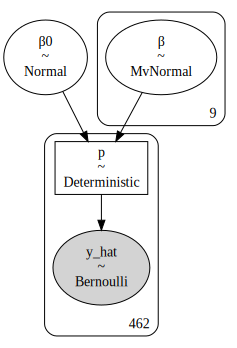

In [66]:
train_shape = train_prepared.shape[1]
with pm.Model() as chd_model:
    β0 = pm.Normal('β0', mu=0, sigma=10)
    β = pm.MvNormal('β', mu=np.zeros(train_shape),cov=np.eye(train_shape),shape=train_shape)
    μ = β0 + pm.math.dot(train_prepared,β)
    p = pm.Deterministic('p', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=p, observed=y_data)
pm.model_to_graphviz(chd_model)

In [54]:
train_prepared.shape[1]

9

In [67]:
with pm.Model() as chd_model:
    β0 = pm.Normal('β0', mu=0, sigma=10)
    β = pm.MvNormal('β', mu=np.zeros(train_shape),cov=np.eye(train_shape),shape=train_shape)
    μ = β0 + pm.math.dot(train_prepared,β)
    p = pm.Deterministic('p', pm.invlogit(μ))
    y_hat = pm.Bernoulli('y_hat', p=p, observed=y_data)
    binout = pm.sample(10000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0, β]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 69 seconds.


In [76]:
advi_fit = pm.fit(50000, method='advi',model=chd_model)

Finished [100%]: Average Loss = 260.75


Text(0.5, 1.0, 'ELBO vs. time')

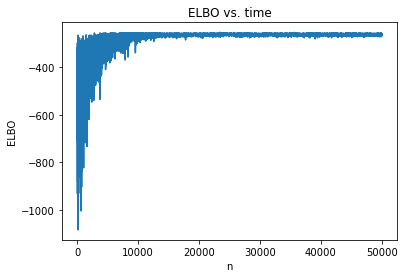

In [77]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n':np.arange(advi_fit.hist.shape[0])
    }
)
ax = sns.lineplot(y='ELBO',x='n',data=advi_elbo)
ax.set_title("ELBO vs. time")

The ELBO plot looks like it converges at about n = 10000. This is faster than convergence for a sampling model.

In [78]:
PPC_SAMPLES = 5000
advi_trace = advi_fit.sample(PPC_SAMPLES)

Text(0.5, 1.0, 'Sampling 94% HDI')

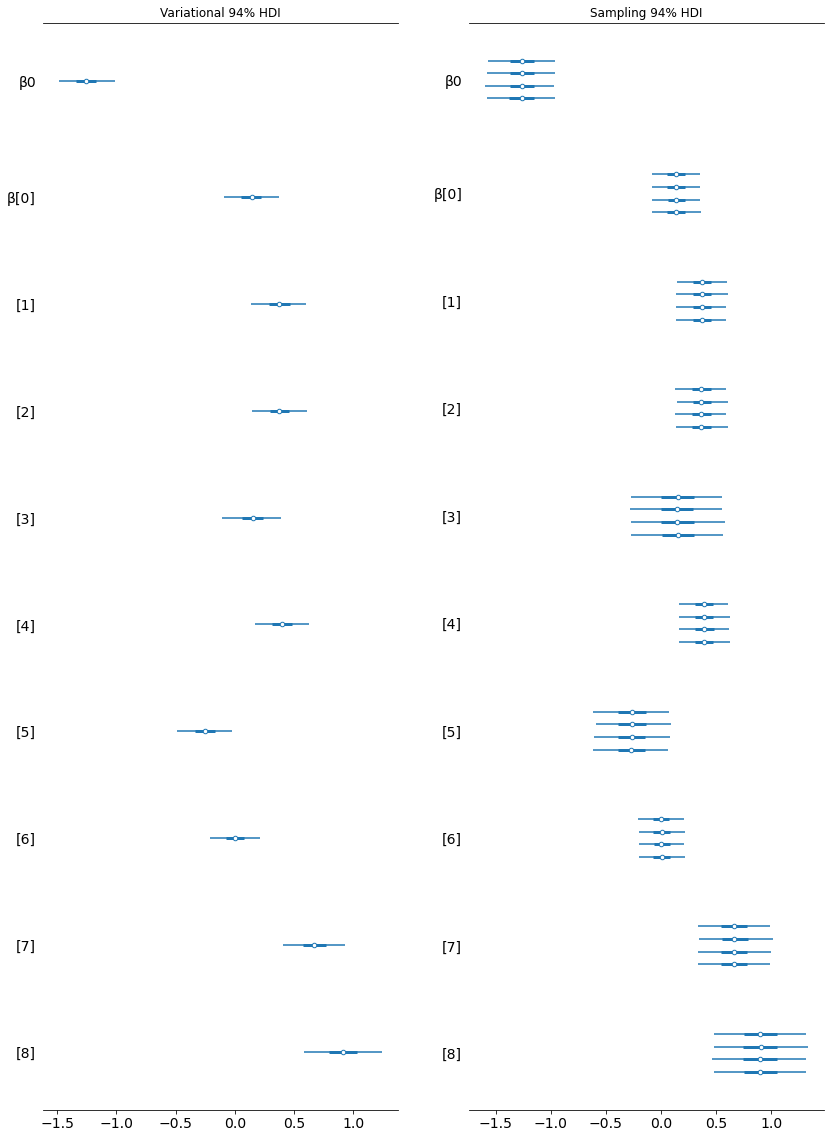

In [96]:
f, (ax1,ax2) = plt.subplots(1,2, sharey=False, figsize = (14,20))
pm.plot_forest(advi_trace, var_names=['β0','β'],ax=ax1)
pm.plot_forest(binout, var_names=['β0','β'],ax=ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

The main difference between variational and sampling is Beta 6. The approximation Beta 6 is pretty much centered on zero, but it is not in the variational method. On the other hand Betas 1,4, and 7 all look fairly similar between the two techniques.

Summary Statistics for Varaiational Model

In [83]:
az.summary(advi_trace,var_names=['β0','β'],round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,-1.25,0.13,-1.48,-1.02,0.0,0.0,5145.76,4940.92,NaN
β[0],0.14,0.12,-0.09,0.37,0.0,0.0,4831.39,4950.50,NaN
β[1],0.37,0.12,0.14,0.60,0.0,0.0,5094.57,4420.95,NaN
β[2],0.38,0.12,0.15,0.61,0.0,0.0,4513.99,4818.65,NaN
β[3],0.15,0.13,-0.11,0.39,0.0,0.0,4700.97,4978.18,NaN
β[4],0.40,0.12,0.17,0.62,0.0,0.0,5188.47,4862.18,NaN
β[5],-0.26,0.12,-0.49,-0.02,0.0,0.0,4666.01,4907.24,NaN
β[6],0.00,0.11,-0.21,0.21,0.0,0.0,4929.65,4981.11,NaN
β[7],0.67,0.14,0.40,0.93,0.0,0.0,5117.78,4572.11,NaN
β[8],0.91,0.18,0.58,1.24,0.0,0.0,4941.87,4415.47,NaN


Summary Statistics for Sampling Model

In [84]:
az.summary(binout,var_names=['β0','β'],round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,-1.26,0.16,-1.58,-0.96,0.0,0.0,44291.44,33655.82,1.0
β[0],0.14,0.12,-0.08,0.35,0.0,0.0,63098.33,32409.05,1.0
β[1],0.37,0.12,0.14,0.60,0.0,0.0,55957.95,33215.23,1.0
β[2],0.37,0.12,0.14,0.60,0.0,0.0,57309.26,32013.69,1.0
β[3],0.15,0.22,-0.28,0.55,0.0,0.0,29685.46,31563.79,1.0
β[4],0.39,0.12,0.16,0.61,0.0,0.0,66046.19,31936.73,1.0
β[5],-0.27,0.18,-0.62,0.07,0.0,0.0,33228.63,32568.73,1.0
β[6],0.00,0.11,-0.20,0.21,0.0,0.0,61219.75,30837.93,1.0
β[7],0.66,0.18,0.34,1.00,0.0,0.0,38692.95,33738.91,1.0
β[8],0.90,0.23,0.47,1.32,0.0,0.0,46269.80,33745.84,1.0


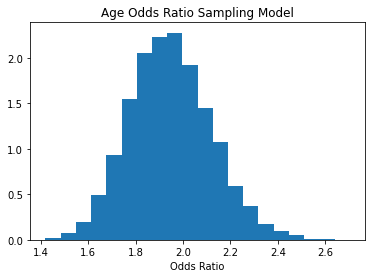

In [106]:
b =  binout.posterior["β"][:,:,7]
OR = np.mean(b, axis =0)
plt.hist(np.exp(OR), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Age Odds Ratio Sampling Model")
plt.show()

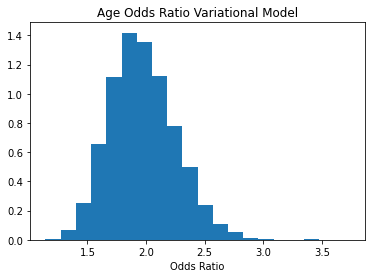

In [107]:
b2 =  advi_trace.posterior["β"][:,:,7]
OR2 = np.mean(b2, axis =0)
plt.hist(np.exp(OR2), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.title("Age Odds Ratio Variational Model")
plt.show()

The odds ratio for age for the sampling model seems centered at around 2, and has a range of about 1.4 to 2.6. The variational model odds ratio is also centered around two, but has a much greater range (from about 1.25 to 3.5). This supports that sampling results in a smaller range of values for the model coefficients, and therefore is more accurate.

In [93]:
lb, ub = np.percentile(OR, 2.5), np.percentile(OR, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

P(1.632 < O.R. < 2.306) = 0.95


In [94]:
lb2, ub2 = np.percentile(OR2, 2.5), np.percentile(OR2, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb2), np.exp(ub2)))

P(1.485 < O.R. < 2.567) = 0.95


These credible intervals confirm the observations made about the Odds Ratio graphs above. The credible interval is larger for the variational model than the credible interval for the sampling model. 

Question 5

In [5]:
data=pd.read_csv("bangladesh.csv")
district = data['district']
contraception = data['use.contraception']

levels = district.unique()
nlevels = district.nunique()

X = np.zeros(shape = (data.shape[0],nlevels))
for i, dis in enumerate(levels):
    X[:,i] = (district == dis)

In [6]:
with pm.Model() as partial_pooling:
    mu_a = pm.Normal('mu_a', mu=0, sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a',5)
    
    a = pm.Normal('a',mu=mu_a, sigma=sigma_a, shape=nlevels)
    y_hat = pm.math.dot(a, X.T)
    y_like = pm.Bernoulli('y_like', logit_p=y_hat,observed=contraception)
    
    trace_pp = pm.sample(10000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 661 seconds.


In [7]:
advi_fit_pp = pm.fit(50000,method = 'advi',model=partial_pooling)

Finished [100%]: Average Loss = 1,286.1


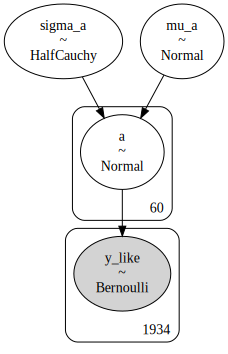

In [8]:
pm.model_to_graphviz(partial_pooling)

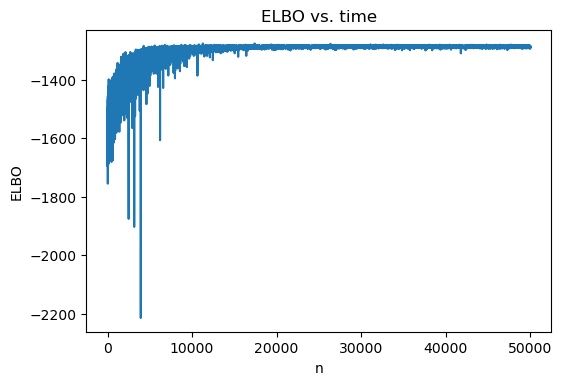

In [9]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit_pp.hist,
     'n': np.arange(advi_fit_pp.hist.shape[0])})
    
plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n',data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

In [10]:
PPC_SAMPLES = 5000
advi_fit_sample = advi_fit_pp.sample(PPC_SAMPLES)

Text(0.5, 1.0, 'Sampling 94% HDI')

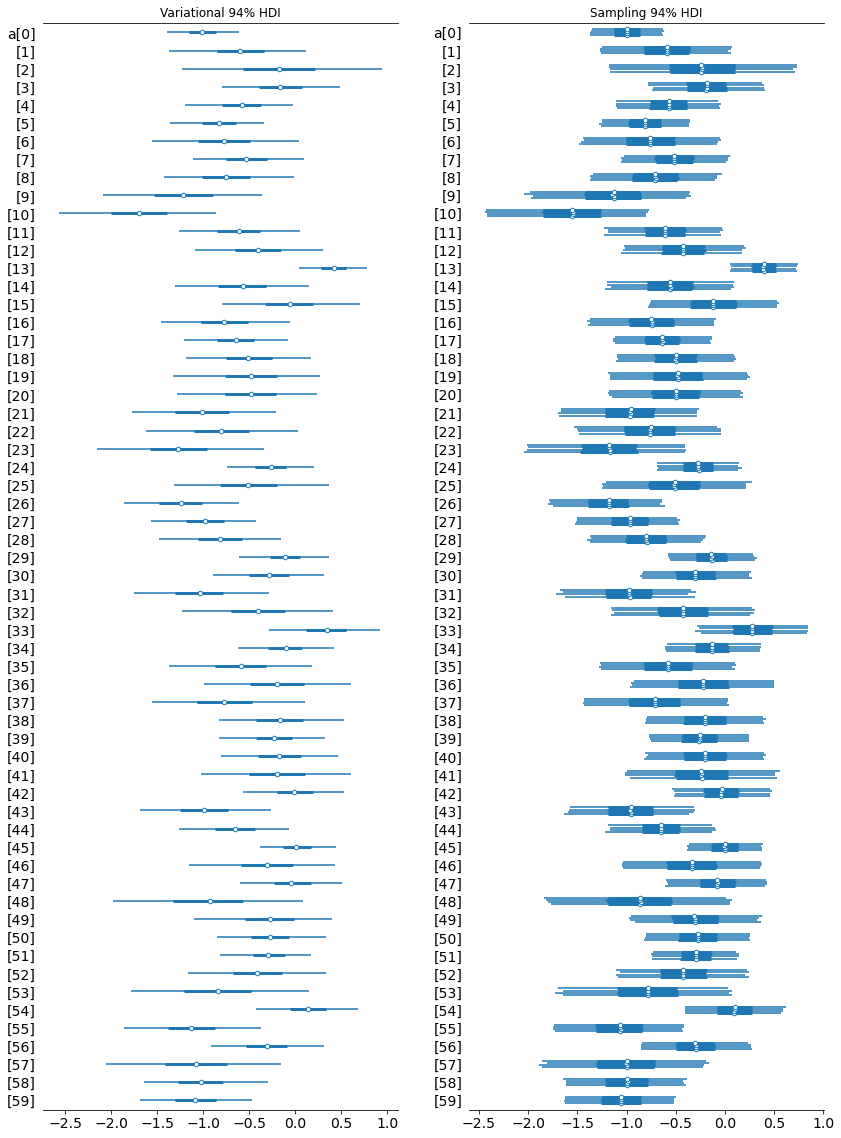

In [11]:
f, (ax1,ax2) = plt.subplots(1,2, sharey=False, figsize=(14,20))

pm.plot_forest(advi_fit_sample, var_names=['a'], ax=ax1)
pm.plot_forest(trace_pp, var_names=['a'],ax=ax2)
ax1.set_title('Variational 94% HDI')
ax2.set_title('Sampling 94% HDI')

For the partial pooled model, the results from variational and sampling methods are very similar. There does not seem to be a noticable difference in the intervals for the coefficient estimates above. However, both of these methods perform poorly for the districts with a small number of samples.